In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# read the words from the input file
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# building the vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [5]:
block_size = 8
# building the data set based on the block size
def build_dataset(words):
    X,Y = [],[]
    for word in words:
        #print(word)
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[c] for c in context), "-->", ch)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,X.dtype, Y.shape, Y.dtype)
    return X,Y

In [6]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
# train split, dev/validation split, test split
# 80 %, 10%, 10%

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182580, 8]) torch.int64 torch.Size([182580]) torch.int64
torch.Size([22767, 8]) torch.int64 torch.Size([22767]) torch.int64
torch.Size([22799, 8]) torch.int64 torch.Size([22799]) torch.int64


In [7]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> b
......eb --> r
.....ebr --> i
....ebri --> m
...ebrim --> a
..ebrima --> .
........ --> h
.......h --> i
......hi --> l
.....hil --> t
....hilt --> o
...hilto --> n
..hilton --> .
........ --> j
.......j --> h
......jh --> e
.....jhe --> n
....jhen --> e
...jhene --> .


In [8]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros((fan_out)) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers (trained with momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
          if x.ndim == 2:
            dim = 0 
          elif x.ndim == 3:
            dim = (0, 1)
          xmean = x.mean(dim, keepdim = True)
          xvar = x.var(dim, keepdim = True)
        else :
          xmean = self.running_mean
          xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]
    
class Embedding:
    
    def __init__(self, num_embedding, embedding_dim):
        self.weights = torch.randn((num_embedding, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weights[IX]
        return self.out
    
    def parameters(self):
        return [self.weights]

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B,T,C = x.shape
        x = x.view(B, T//self.n, self.n * C)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [9]:
torch.manual_seed(42);

In [10]:
n_embd = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias = False),BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False),BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [11]:
losses = []
max_steps = 200000
batch_size = 32
for i in range(max_steps):
    # mini-batch selection
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 150000 else 0.01
    # update params
    for p in parameters:
        p.data += -lr * p.grad
    
    # track status
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item())

      0/ 200000: 3.3088
  10000/ 200000: 2.4522
  20000/ 200000: 2.1598
  30000/ 200000: 2.6426
  40000/ 200000: 1.8248
  50000/ 200000: 2.5059
  60000/ 200000: 2.1407
  70000/ 200000: 1.8225
  80000/ 200000: 2.0721
  90000/ 200000: 1.7829
 100000/ 200000: 2.0264
 110000/ 200000: 2.0252
 120000/ 200000: 1.8361
 130000/ 200000: 1.8880
 140000/ 200000: 1.7401
 150000/ 200000: 1.9735
 160000/ 200000: 1.7228
 170000/ 200000: 1.9166
 180000/ 200000: 2.3637
 190000/ 200000: 1.7630


In [12]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 128])

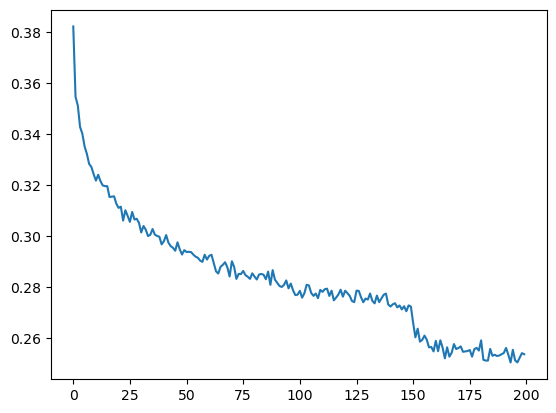

In [13]:
#plt.plot(losses)
#better way
plt.plot(torch.tensor(losses).view(-1,1000).mean(1))

In [14]:
for layer in model.layers:
    layer.training = False

In [15]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 1.7669143676757812
val 1.9844632148742676


##### performance logging
##### When using normal NN, with block_size equals 8, (Total parameter: 22K)

*   train - 1.9203474521636963, 
*   val - 2.0419790744781494

##### When using normal Wavenet architecture NN (Hierarchical), with block_size equals 8, (Total parameter: 22K)

*  train - 1.9397433996200562
*  val - 2.0300967693328857

##### When using normal Wavenet architecture NN (Hierarchical), with block_size equals 8, (Total parameter: 22K, Note: BatchNorm is fixed)

*  train - 1.9112377166748047
*  val   - 2.0205328464508057

##### When using normal Wavenet architecture NN (Hierarchical), with block_size equals 8, (Total parameter: 76K, Note: BatchNorm is fixed)
* train - 1.7669143676757812
* val  - 1.9844632148742676


In [16]:
# sample from the model
for _ in range(20):
    out = []
    context = [0]* block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

abeljah.
ottavious.
santi.
emmelynn.
aisam.
aisabrie.
jerina.
mannsley.
teau.
aranza.
raniyah.
layveon.
zayell.
cassidine.
remita.
niyecha.
jaylene.
abyan.
aubreana.
ilyra.
